In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
python3 = True

# Environment variables setting

In [2]:
# Setting environment variables
import sys, os
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")
if python3: os.environ['PYSPARK_PYTHON'] = "vsb/CI_conda_env_py3/bin/python"

# Import of useful packages and modules

In [3]:
import pandas as pd
pd.set_option('max_colwidth', None)
import itertools
import numpy as np
from numpy import nanargmax
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
import sklearn
import time
from pandas.core.common import flatten
import pickle
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
# Importing spark libs
from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
import pyspark.sql.types as types
from pyspark.mllib.stat import Statistics
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import classification_report, confusion_matrix

# Spark configuration 

In [4]:
# Stopping the current session if exists
try:
    session.stop()
except:
    pass

In [5]:
# Setting up the spark configurator  
conf = SparkConf()
conf.set('spark.serializer', "org.apache.spark.serializer.KryoSerializer")       
conf.set('spark.executor.memory', '16g')
conf.set('spark.driver.memory', '16g')
conf.set('spark.executor.cores', '3')
conf.set('spark.driver.cores', '3')
conf.set('spark.dynamicAllocation.enabled', 'true')
conf.set('spark.executor.instances', '4')
conf.set('spark.dynamicAllocation.minExecutors', '4')
conf.set('spark.dynamicAllocation.maxExecutors', '12')
conf.set('spark.executor.memoryOverhead', '8096')
conf.set('spark.driver.memoryOverhead', '8096')
conf.set('spark.driver.maxResultSize', '20g')
conf.set('spark.kryoserializer.buffer.max', '2047')
conf.setAppName('DA_Modeling_Small_Medium_3_months')
if python3: conf.set("spark.yarn.dist.archives", "/home/anxadvuser/anx_adv_achurn/env_conda_py3.zip#vsb")

# Creating the spark session object
session = SparkSession.builder.config(conf=conf).enableHiveSupport().getOrCreate()

In [6]:
session

# Modeling

In [7]:
train_set_features_selected_small_medium = session.read.parquet("/bda/anx_adv_achurn/durand/train_set_features_selected_small_medium").cache()
test_set_features_selected_small_medium = session.read.parquet("/bda/anx_adv_achurn/durand/test_set_features_selected_small_medium").cache()

In [8]:
train_set_subset_small_medium = session.read.parquet("/bda/anx_adv_achurn/durand/train_set_small_medium_balanced_numeric_subset").cache()

In [9]:
train_set_features_selected_small_medium.count()

8166818

In [10]:
test_set_features_selected_small_medium.count()

1052729

In [11]:
def dtypes(df_in):
    """
    Generate the data type categories: numerical, categorical, date and unsupported category.
    :param df_in: the input rdd data frame
    :return: data type categories
    """

    # all data types in pyspark (for reference)
    # __all__ = [
    # "DataType", "NullType", "StringType", "BinaryType", "BooleanType", "DateType",
    # "TimestampType", "DecimalType", "DoubleType", "FloatType", "ByteType", "IntegerType",
    # "LongType", "ShortType", "ArrayType", "MapType", "StructField", "StructType"]

    # numerical data types in rdd DataFrame dtypes
    num_types = ['DecimalType', 'DoubleType', 'FloatType', 'ByteType', 'IntegerType', 'LongType', 'ShortType']
    # qualitative data types in rdd DataFrame dtypes
    cat_types = ['NullType', 'StringType', 'BinaryType', 'BooleanType']
    # date data types in rdd DataFrame dtypes
    date_types = ['DateType', 'TimestampType']
    # unsupported data types in rdd DataFrame dtypes
    unsupported_types = ['ArrayType', 'MapType', 'StructField', 'StructType']

    all_fields = [(f.name, str(f.dataType)) for f in df_in.schema.fields]

    all_df = pd.DataFrame(all_fields, columns=['feature', 'DataType'])

    # initialize the memory for the corresponding fields
    num_fields = []
    cat_fields = []
    date_fields = []
    unsupported_fields = []

    [num_fields.append(item[0]) if item[1] in num_types else
     cat_fields.append(item[0]) if item[1] in cat_types else
     date_fields.append(item[0]) if item[1] in date_types else
     unsupported_fields.append(item[0]) for item in all_fields]

    return all_df, num_fields, cat_fields, date_fields, unsupported_fields


def get_encoded_names(df_in, categorical_cols):
    """
    get the encoded dummy variable names
    :param df_in: the input dataframe
    :param categorical_cols: the name list of the categorical columns
    :return: the name list of the encoded dummy variable for categorical columns
    """

    ind_names = [df_in.groupBy(c).count().sort(F.col("count").desc()).select(c).rdd.flatMap(lambda x: x).collect()
                 for c in categorical_cols]

    encodered_name = [categorical_cols[i] + '_' + j for i in range(len(categorical_cols)) for j in ind_names[i]]

    return encodered_name


def get_assembled_data(df_in, index_col=None, categorical_cols=None, continuous_cols=None, label_col=None, dropLast=False):
    """
    Get dummy variables and concat with continuous variables for ml modeling.
    :param df_in: the dataframe
    :param categorical_cols: the name list of the categorical data
    :param continuous_cols:  the name list of the numerical data
    :param label_col:  the name of label column
    :param dropLast:  the flag of drop last column
    :return: encoded dummy variable names and feature matrix
    """

    # exclude index col and label col
    excluded = list(flatten([index_col, label_col]))

    if continuous_cols:
        continuous_cols = [col for col in continuous_cols if col not in excluded]
    else:
        continuous_cols = []

    if categorical_cols:
        categorical_cols = [col for col in categorical_cols if col not in excluded]
    else:
        categorical_cols = []

    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in categorical_cols]

    # default setting: dropLast=True
    encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(),
                              outputCol="{0}_encoded".format(indexer.getOutputCol()), dropLast=dropLast)
                for indexer in indexers]

    assembler = VectorAssembler(inputCols=continuous_cols + [encoder.getOutputCol() for encoder in encoders],
                                outputCol="assembled_features")
    
    # Standard Scaler: 
    #We use the Standard Scaler to put all the numbers on the same scale, which is standard practice 
    #for machine learning. This takes the observation and subtracts the mean, and then divides that 
    #by the standard deviation.
    
    standardscaler = StandardScaler().setInputCol("assembled_features").setOutputCol("features")
    
    pipeline = Pipeline(stages=indexers + encoders + [assembler] + [standardscaler])

    encodered_col_names = get_encoded_names(df_in, categorical_cols)
    assembled_col_names = continuous_cols + encodered_col_names

    model = pipeline.fit(df_in)
    data = model.transform(df_in)

    if index_col and label_col:
        # for supervised learning
        data = data.withColumn('label', F.col(label_col))
        out_data = data.select(*list(flatten([index_col, 'features', 'label'])))
    elif not index_col and label_col:
        # for supervised learning
        data = data.withColumn('label', F.col(label_col))
        out_data = data.select('features', 'label')
    elif index_col and not label_col:
        # for unsupervised learning
        out_data = data.select(*list(flatten([index_col, 'features'])))
    elif not index_col and not label_col:
        # for unsupervised learning
        out_data = data.select('features')

    return assembled_col_names, out_data


def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    
    if cmap is None:
        cmap = plt.get_cmap('copper')
        
    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.rcParams.update({'font.size': 12})
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.show()
    plt.close()
    
def plot_roc_curve(predictions_df, label_col, churn_proba_col, model_name):
    np.seterr(divide='ignore', invalid='ignore')
    
    y = predictions_df[label_col]
    y_hat = predictions_df[churn_proba_col]
    
    # calculate inputs for the roc curve
    fpr, tpr, thresholds = roc_curve(y, y_hat)
    
    # calculate the area under the roc curve
    roc_auc = roc_auc_score(y, y_hat)

    # get the best threshold
    J = tpr - fpr
    ix = nanargmax(J)
    best_thresh = thresholds[ix]
    
    # style
    plt.style.use('seaborn-darkgrid')

    # plot roc curve
    plt.rcParams.update({'font.size': 12})
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, marker = '', label = model_name)
    
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # title
    plt.title('ROC Curve {}'.format(model_name))
    
    # show the plot
    plt.show()
    plt.close()
    
    np.seterr(divide='warn', invalid='warn')
    return roc_auc, best_thresh
    
def plot_pr_curve(predictions_df, label_col, churn_proba_col, model_name):
    np.seterr(divide='ignore', invalid='ignore')
    
    y = predictions_df[label_col]
    y_hat = predictions_df[churn_proba_col]
    
    # calculate inputs for the PR curve
    precision, recall, thresholds = precision_recall_curve(y, y_hat)
    
    # calculate the area under the pr curve
    pr_auc = auc(recall, precision)
    
    # Calculate F-Scores and find the index of ideal score
    fscores = (2 * precision * recall) / (precision + recall)
    ix = nanargmax(fscores)
    best_thresh = thresholds[ix]

    # style
    plt.style.use('seaborn-darkgrid')
    
    # plot PR curve
    plt.rcParams.update({'font.size': 12})
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, marker = '', label = model_name)

    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    # title
    plt.title('Precision-Recall Curve {}'.format(model_name))

    # show the plot
    plt.show()
    plt.close()
    
    np.seterr(divide='warn', invalid='warn')
    return pr_auc, best_thresh

def find_best_threshold(predictions_df, label_col, churn_proba_col, model_name):
    
    # Plot ROC Curve
    roc_auc, best_thresh_roc_curve = plot_roc_curve(predictions_df, label_col, churn_proba_col, model_name)
    
    # Plot PR Curve
    print()
    pr_auc, best_thresh_pr_curve = plot_pr_curve(predictions_df, label_col, churn_proba_col, model_name)
    
    return roc_auc, pr_auc, best_thresh_roc_curve, best_thresh_pr_curve
    
def evaluate_model(confusion_matrix, model_name):
    # Plot Confusion Matrix
    plot_confusion_matrix(cm = confusion_matrix, normalize = False, target_names = ['stay', 'churn'], 
                          title = "Confusion Matrix {}".format(model_name), cmap="Blues")
    
    # True Positive
    tp = confusion_matrix[1][1]
    # False Positive
    fp = confusion_matrix[0][1]
    # Tue Negative
    tn = confusion_matrix[0][0]
    # False Negative
    fn = confusion_matrix[1][0]
    
    precision = (tp/(tp+fp))
    recall = (tp/(tp+fn))
    fscore = (2*precision*recall)/(precision+recall)
    
    return precision, recall, fscore

def conpute_confusion_matrix(predictions_df, predictions_col, label_col):
    results = predictions_df.select([predictions_col, label_col])
    predictionAndLabels = results.rdd
    metrics = MulticlassMetrics(predictionAndLabels)
    cm = metrics.confusionMatrix().toArray()
    return cm

def split_proba_column(predictions_df, proba_col):
    firstelement = udf(lambda v:float(v[0]),FloatType())
    secondelement = udf(lambda v:float(v[1]),FloatType())
    predictions_df = predictions_df.withColumn('stay_probability', firstelement(proba_col))
    predictions_df = predictions_df.withColumn('churn_probability', secondelement(proba_col))
    return predictions_df

def metrics_to_pandas(model, precision, recall, fscore, roc_auc, pr_auc, roc_best_threshold = None, pr_best_threshold = None):
    if (roc_best_threshold == None and pr_best_threshold == None):
        metrics_dict = {
            'Model': [model],
            'Default Threshold': [0.5],
            'Precision (%)': [precision * 100],
            'Recall (%)': [recall * 100],
            'F1 Score (%)': [fscore * 100],
            'ROC AUC': [roc_auc],
            'PR AUC': [pr_auc]
        }
    if roc_best_threshold != None:
        metrics_dict = {
            'Model': [model],
            'ROC Best Threshold': [roc_best_threshold],
            'Precision (%)': [precision * 100],
            'Recall (%)': [recall * 100],
            'F1 Score (%)': [fscore * 100],
            'ROC AUC': [roc_auc],
            'PR AUC': [pr_auc]
        }
    if pr_best_threshold != None:
        metrics_dict = {
            'Model': [model],
            'PR Best Threshold': [pr_best_threshold],
            'Precision (%)': [precision * 100],
            'Recall (%)': [recall * 100],
            'F1 Score (%)': [fscore * 100],
            'ROC AUC': [roc_auc],
            'PR AUC': [pr_auc]
        }
        
    metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index').transpose()
    return metrics_df

def get_optimal_threshold_results(predictions_df, threshold, proba_col, new_prediction_col):
    predictions_df = predictions_df.withColumn(new_prediction_col, 
                                               F.when(F.col(proba_col) < float(threshold), 0.0).otherwise(1.0)
                                              )
    return predictions_df

Preparing the data: both test and training set

In [12]:
# get_assembled_data test - this function is used to have the data in the correct form to apply any pyspark model
indexCols = ['fk_cliente_unico', 'idn_cliente_sk', 'idc_id_key_cliente', 'idn_servizio_sk', 'idc_id_key_servizio', 'idn_contratto_sk', 'idc_id_key_contratto', 'cdc_pdr', 'val_churn_2_months']
labelCol = 'val_churn_3_months'

_, train_continuous_cols_small_medium, train_categorical_cols_small_medium, _, _ = dtypes(train_set_features_selected_small_medium)
_, test_continuous_cols_small_medium, test_categorical_cols_small_medium, _, _ = dtypes(test_set_features_selected_small_medium)

train_continuous_cols_small_medium = [c for c in train_continuous_cols_small_medium if c != 'cdc_bolletta_web']
test_continuous_cols_small_medium = [c for c in train_continuous_cols_small_medium if c != 'cdc_bolletta_web']

train_set_assembled_col_names_small_medium, assembled_train_set_small_medium = get_assembled_data(train_set_features_selected_small_medium, 
                                                                                                  index_col = indexCols, 
                                                                                                  categorical_cols = train_categorical_cols_small_medium,
                                                                                                  continuous_cols = train_continuous_cols_small_medium, 
                                                                                                  label_col = labelCol
                                                                                                 )

test_set_assembled_col_names_small_medium, assembled_test_set_small_medium = get_assembled_data(test_set_features_selected_small_medium, 
                                                                                                index_col = indexCols, 
                                                                                                categorical_cols = test_categorical_cols_small_medium,
                                                                                                continuous_cols = test_continuous_cols_small_medium, 
                                                                                                label_col = labelCol
                                                                                               )

print(len(train_set_assembled_col_names_small_medium))

54


## Small and Medium

In [13]:
metrics_perc_dict_small_medium = {
    'Model': [],
    'Default Threshold': [],
    'Precision (%)': [],
    'Recall (%)': [],
    'F1 Score (%)': [],
    'ROC AUC': [],
    'PR AUC': []
}

metrics_perc_dict_roc_th_small_medium = {
    'Model': [],
    'ROC Best Threshold': [],
    'Precision (%)': [],
    'Recall (%)': [],
    'F1 Score (%)': [],
    'ROC AUC': [],
    'PR AUC': []
}

metrics_perc_dict_pr_th_small_medium = {
    'Model': [],
    'PR Best Threshold': [],
    'Precision (%)': [],
    'Recall (%)': [],
    'F1 Score (%)': [],
    'ROC AUC': [],
    'PR AUC': []
}

### Logistic Regression

#### Building

In [14]:
# Train Logistic Regession model
lr_small_medium = LogisticRegression(labelCol="label", featuresCol="features", maxIter=50)
lr_model_small_medium=lr_small_medium.fit(assembled_train_set_small_medium)
predict_train_lr_small_medium=lr_model_small_medium.transform(assembled_train_set_small_medium)
predict_test_lr_small_medium=lr_model_small_medium.transform(assembled_test_set_small_medium)

In [15]:
predict_test_lr_small_medium = split_proba_column(predictions_df = predict_test_lr_small_medium, proba_col = 'probability')
cm_lr_small_medium = conpute_confusion_matrix(predict_test_lr_small_medium, 'prediction', 'label')
results_lr_small_medium = predict_test_lr_small_medium.select('label', 'probability', 'stay_probability', 'churn_probability', 'prediction').toPandas()

#### Evaluation

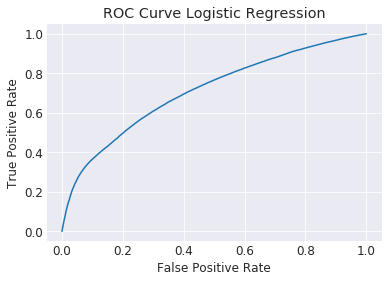

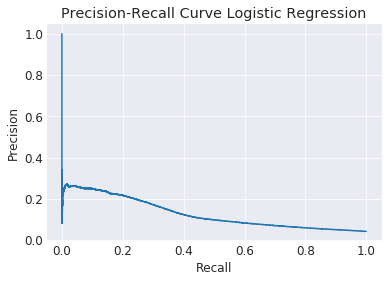

In [16]:
# Best threshold calculation and areas under the curves 
roc_auc_lr_small_medium, pr_auc_lr_small_medium, best_thresh_roc_curve_lr_small_medium, best_thresh_pr_curve_lr_small_medium = find_best_threshold(
    predictions_df = results_lr_small_medium,
    label_col = 'label',
    churn_proba_col = 'churn_probability',
    model_name = 'Logistic Regression'
)

In [17]:
# Threshold optimization: with ROC Curve best threshold
predict_test_lr_small_medium = get_optimal_threshold_results(
    predictions_df = predict_test_lr_small_medium, 
    threshold = best_thresh_roc_curve_lr_small_medium,
    proba_col = 'churn_probability',
    new_prediction_col = 'prediction_roc_th'
)
# Threshold optimization: with PR Curve best threshold
predict_test_lr_small_medium = get_optimal_threshold_results(
    predictions_df = predict_test_lr_small_medium, 
    threshold = best_thresh_pr_curve_lr_small_medium,
    proba_col = 'churn_probability',
    new_prediction_col = 'prediction_pr_th'
)

In [18]:
# Computing the new confusion matrix: ROC Curve best threshold
cm_roc_lr_small_medium = conpute_confusion_matrix(predict_test_lr_small_medium, 'prediction_roc_th', 'label')

# Computing the new confusion matrix: PR Curve best threshold
cm_pr_lr_small_medium = conpute_confusion_matrix(predict_test_lr_small_medium, 'prediction_pr_th', 'label')

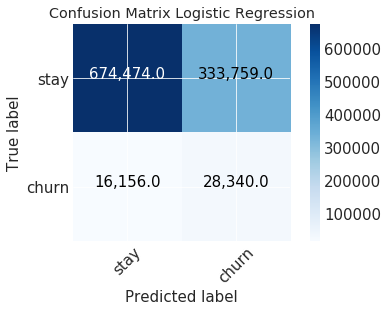

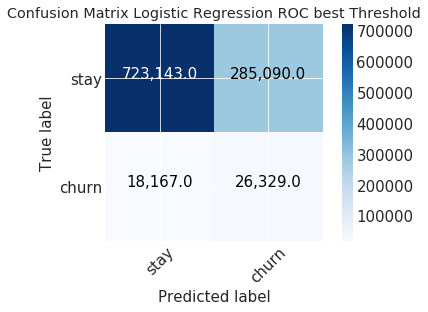

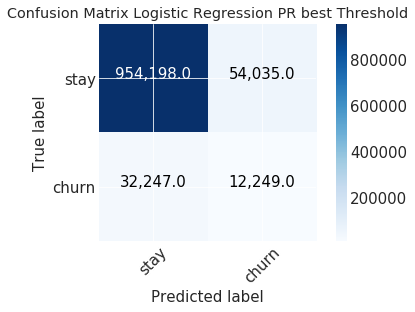

In [19]:
# Evaluation metrics calculation
precision_lr_small_medium, recall_lr_small_medium, fscore_lr_small_medium = evaluate_model(
    confusion_matrix = cm_lr_small_medium,  
    model_name = 'Logistic Regression'
)

# Computing new evaluation metrics: ROC Curve best threshold
precision_roc_lr_small_medium, recall_roc_lr_small_medium, fscore_roc_lr_small_medium = evaluate_model(
    confusion_matrix = cm_roc_lr_small_medium,
    model_name = 'Logistic Regression ROC best Threshold'
)

# Computing new evaluation metrics: PR Curve best threshold
precision_pr_lr_small_medium, recall_pr_lr_small_medium, fscore_pr_lr_small_medium = evaluate_model(
    confusion_matrix = cm_pr_lr_small_medium,
    model_name = 'Logistic Regression PR best Threshold'
)

In [20]:
#Displaying Evaluation metrics as pandas dataframe
metrics_lr_small_medium = metrics_to_pandas(
    model = 'Logistic Regression Small-Medium',
    precision = precision_lr_small_medium, 
    recall = recall_lr_small_medium, 
    fscore = fscore_lr_small_medium, 
    roc_auc = roc_auc_lr_small_medium, 
    pr_auc = pr_auc_lr_small_medium
)
print("Metrics before threshold optimization: ")
display(metrics_lr_small_medium)

#Displaying new evaluation metrics: ROC Curve best threshold
metrics_roc_lr_small_medium = metrics_to_pandas(
    model = 'Logistic Regression Small-Medium',
    precision = precision_roc_lr_small_medium, 
    recall = recall_roc_lr_small_medium, 
    fscore = fscore_roc_lr_small_medium, 
    roc_auc = roc_auc_lr_small_medium, 
    pr_auc = pr_auc_lr_small_medium,
    roc_best_threshold = best_thresh_roc_curve_lr_small_medium
)

#Displaying new evaluation metrics: PR Curve best threshold
metrics_pr_lr_small_medium = metrics_to_pandas(
    model = 'Logistic Regression Small-Medium',
    precision = precision_pr_lr_small_medium, 
    recall = recall_pr_lr_small_medium, 
    fscore = fscore_pr_lr_small_medium, 
    roc_auc = roc_auc_lr_small_medium, 
    pr_auc = pr_auc_lr_small_medium,
    pr_best_threshold = best_thresh_pr_curve_lr_small_medium
)

print("Metrics After threshold optimization - ROC best threshold: ")
display(metrics_roc_lr_small_medium)
print("Metrics After threshold optimization - PR best threshold: ")
display(metrics_pr_lr_small_medium)

Metrics before threshold optimization: 


,Model,Default Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Logistic Regression Small-Medium,0.5,7.82659,63.6911,13.9402,0.709553,0.12704


Metrics After threshold optimization - ROC best threshold: 


,Model,ROC Best Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Logistic Regression Small-Medium,0.516041,8.45453,59.1716,14.7951,0.709553,0.12704


Metrics After threshold optimization - PR best threshold: 


,Model,PR Best Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Logistic Regression Small-Medium,0.711785,18.4796,27.5283,22.1141,0.709553,0.12704


In [21]:
metrics_perc_dict_small_medium['Model'].append('Logistic Regression Small-Medium')
metrics_perc_dict_small_medium['Default Threshold'].append(0.5)
metrics_perc_dict_small_medium['Precision (%)'].append(precision_lr_small_medium*100)
metrics_perc_dict_small_medium['Recall (%)'].append(recall_lr_small_medium*100)
metrics_perc_dict_small_medium['F1 Score (%)'].append(fscore_lr_small_medium*100)
metrics_perc_dict_small_medium['ROC AUC'].append(roc_auc_lr_small_medium)
metrics_perc_dict_small_medium['PR AUC'].append(pr_auc_lr_small_medium)

metrics_perc_dict_roc_th_small_medium['Model'].append('Logistic Regression Small-Medium')
metrics_perc_dict_roc_th_small_medium['ROC Best Threshold'].append(best_thresh_roc_curve_lr_small_medium)
metrics_perc_dict_roc_th_small_medium['Precision (%)'].append(precision_roc_lr_small_medium*100)
metrics_perc_dict_roc_th_small_medium['Recall (%)'].append(recall_roc_lr_small_medium*100)
metrics_perc_dict_roc_th_small_medium['F1 Score (%)'].append(fscore_roc_lr_small_medium*100)
metrics_perc_dict_roc_th_small_medium['ROC AUC'].append(roc_auc_lr_small_medium)
metrics_perc_dict_roc_th_small_medium['PR AUC'].append(pr_auc_lr_small_medium)

metrics_perc_dict_pr_th_small_medium['Model'].append('Logistic Regression Small-Medium')
metrics_perc_dict_pr_th_small_medium['PR Best Threshold'].append(best_thresh_pr_curve_lr_small_medium)
metrics_perc_dict_pr_th_small_medium['Precision (%)'].append(precision_pr_lr_small_medium*100)
metrics_perc_dict_pr_th_small_medium['Recall (%)'].append(recall_pr_lr_small_medium*100)
metrics_perc_dict_pr_th_small_medium['F1 Score (%)'].append(fscore_pr_lr_small_medium*100)
metrics_perc_dict_pr_th_small_medium['ROC AUC'].append(roc_auc_lr_small_medium)
metrics_perc_dict_pr_th_small_medium['PR AUC'].append(pr_auc_lr_small_medium)

### Random forest classifier

A random forest is a machine learning classification algorithm. Random forests are generated collections of decision trees.

#### Building

In [22]:
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from time import *

In [23]:
rf_small_medium = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=50)
rf_model_small_medium = rf_small_medium.fit(assembled_train_set_small_medium)
predict_train_rf_small_medium = rf_model_small_medium.transform(assembled_train_set_small_medium)
predict_test_rf_small_medium = rf_model_small_medium.transform(assembled_test_set_small_medium)

In [24]:
predict_test_rf_small_medium = split_proba_column(predictions_df = predict_test_rf_small_medium, proba_col = 'probability')
cm_rf_small_medium = conpute_confusion_matrix(predict_test_rf_small_medium, 'prediction', 'label')
results_rf_small_medium = predict_test_rf_small_medium.select('label', 'probability', 'stay_probability', 'churn_probability', 'prediction').toPandas()

#### Evaluation

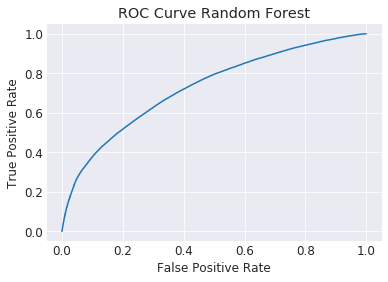

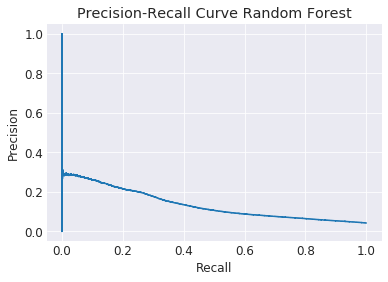

In [25]:
# Best threshold calculation and areas under the curves 
roc_auc_rf_small_medium, pr_auc_rf_small_medium, best_thresh_roc_curve_rf_small_medium, best_thresh_pr_curve_rf_small_medium = find_best_threshold(
    predictions_df = results_rf_small_medium,
    label_col = 'label',
    churn_proba_col = 'churn_probability',
    model_name = 'Random Forest'
)

In [26]:
# Threshold optimization: with ROC Curve best threshold
predict_test_rf_small_medium = get_optimal_threshold_results(
    predictions_df = predict_test_rf_small_medium, 
    threshold = best_thresh_roc_curve_rf_small_medium,
    proba_col = 'churn_probability',
    new_prediction_col = 'prediction_roc_th'
)
# Threshold optimization: with PR Curve best threshold
predict_test_rf_small_medium = get_optimal_threshold_results(
    predictions_df = predict_test_rf_small_medium, 
    threshold = best_thresh_pr_curve_rf_small_medium,
    proba_col = 'churn_probability',
    new_prediction_col = 'prediction_pr_th'
)

In [27]:
# Computing the new confusion matrix: ROC Curve best threshold
cm_roc_rf_small_medium = conpute_confusion_matrix(predict_test_rf_small_medium, 'prediction_roc_th', 'label')

# Computing the new confusion matrix: PR Curve best threshold
cm_pr_rf_small_medium = conpute_confusion_matrix(predict_test_rf_small_medium, 'prediction_pr_th', 'label')

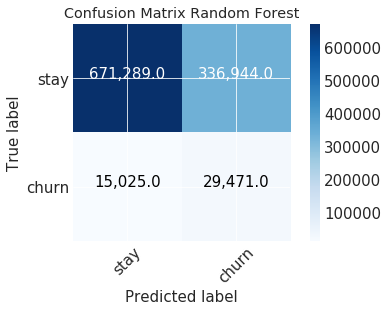

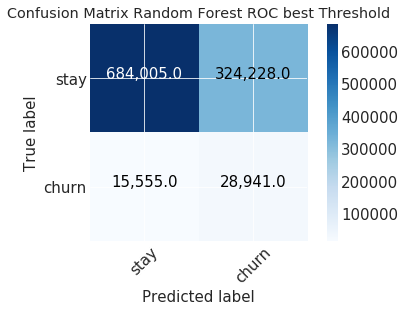

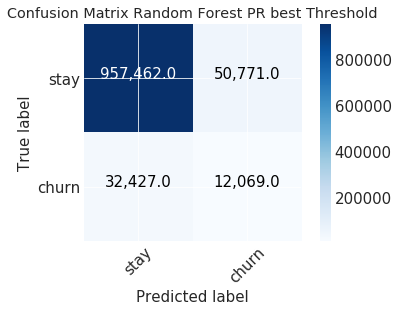

In [28]:
# Evaluation metrics calculation
precision_rf_small_medium, recall_rf_small_medium, fscore_rf_small_medium = evaluate_model(
    confusion_matrix = cm_rf_small_medium,  
    model_name = 'Random Forest'
)

# Computing new evaluation metrics: ROC Curve best threshold
precision_roc_rf_small_medium, recall_roc_rf_small_medium, fscore_roc_rf_small_medium = evaluate_model(
    confusion_matrix = cm_roc_rf_small_medium,
    model_name = 'Random Forest ROC best Threshold'
)

# Computing new evaluation metrics: PR Curve best threshold
precision_pr_rf_small_medium, recall_pr_rf_small_medium, fscore_pr_rf_small_medium = evaluate_model(
    confusion_matrix = cm_pr_rf_small_medium,
    model_name = 'Random Forest PR best Threshold'
)

In [29]:
#Displaying Evaluation metrics as pandas dataframe
metrics_rf_small_medium = metrics_to_pandas(
    model = 'Random Forest Small-Medium',
    precision = precision_rf_small_medium, 
    recall = recall_rf_small_medium, 
    fscore = fscore_rf_small_medium, 
    roc_auc = roc_auc_rf_small_medium, 
    pr_auc = pr_auc_rf_small_medium
)
print("Metrics before threshold optimization: ")
display(metrics_rf_small_medium)

#Displaying new evaluation metrics: ROC Curve best threshold
metrics_roc_rf_small_medium = metrics_to_pandas(
    model = 'Random Forest Small-Medium',
    precision = precision_roc_rf_small_medium, 
    recall = recall_roc_rf_small_medium, 
    fscore = fscore_roc_rf_small_medium, 
    roc_auc = roc_auc_rf_small_medium, 
    pr_auc = pr_auc_rf_small_medium,
    roc_best_threshold = best_thresh_roc_curve_rf_small_medium
)

#Displaying new evaluation metrics: PR Curve best threshold
metrics_pr_rf_small_medium = metrics_to_pandas(
    model = 'Random Forest Small-Medium',
    precision = precision_pr_rf_small_medium, 
    recall = recall_pr_rf_small_medium, 
    fscore = fscore_pr_rf_small_medium, 
    roc_auc = roc_auc_rf_small_medium, 
    pr_auc = pr_auc_rf_small_medium,
    pr_best_threshold = best_thresh_pr_curve_rf_small_medium
)

print("Metrics After threshold optimization - ROC best threshold: ")
display(metrics_roc_rf_small_medium)
print("Metrics After threshold optimization - PR best threshold: ")
display(metrics_pr_rf_small_medium)

Metrics before threshold optimization: 


,Model,Default Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Random Forest Small-Medium,0.5,8.04307,66.2329,14.3442,0.727338,0.134614


Metrics After threshold optimization - ROC best threshold: 


,Model,ROC Best Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Random Forest Small-Medium,0.502633,8.19466,65.0418,14.5555,0.727338,0.134614


Metrics After threshold optimization - PR best threshold: 


,Model,PR Best Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Random Forest Small-Medium,0.59424,19.2059,27.1238,22.4883,0.727338,0.134614


In [30]:
metrics_perc_dict_small_medium['Model'].append('Random Forest Small-Medium')
metrics_perc_dict_small_medium['Default Threshold'].append(0.5)
metrics_perc_dict_small_medium['Precision (%)'].append(precision_rf_small_medium*100)
metrics_perc_dict_small_medium['Recall (%)'].append(recall_rf_small_medium*100)
metrics_perc_dict_small_medium['F1 Score (%)'].append(fscore_rf_small_medium*100)
metrics_perc_dict_small_medium['ROC AUC'].append(roc_auc_rf_small_medium)
metrics_perc_dict_small_medium['PR AUC'].append(pr_auc_rf_small_medium)

metrics_perc_dict_roc_th_small_medium['Model'].append('Random Forest Small-Medium')
metrics_perc_dict_roc_th_small_medium['ROC Best Threshold'].append(best_thresh_roc_curve_rf_small_medium)
metrics_perc_dict_roc_th_small_medium['Precision (%)'].append(precision_roc_rf_small_medium*100)
metrics_perc_dict_roc_th_small_medium['Recall (%)'].append(recall_roc_rf_small_medium*100)
metrics_perc_dict_roc_th_small_medium['F1 Score (%)'].append(fscore_roc_rf_small_medium*100)
metrics_perc_dict_roc_th_small_medium['ROC AUC'].append(roc_auc_rf_small_medium)
metrics_perc_dict_roc_th_small_medium['PR AUC'].append(pr_auc_rf_small_medium)

metrics_perc_dict_pr_th_small_medium['Model'].append('Random Forest Small-Medium')
metrics_perc_dict_pr_th_small_medium['PR Best Threshold'].append(best_thresh_pr_curve_rf_small_medium)
metrics_perc_dict_pr_th_small_medium['Precision (%)'].append(precision_pr_rf_small_medium*100)
metrics_perc_dict_pr_th_small_medium['Recall (%)'].append(recall_pr_rf_small_medium*100)
metrics_perc_dict_pr_th_small_medium['F1 Score (%)'].append(fscore_pr_rf_small_medium*100)
metrics_perc_dict_pr_th_small_medium['ROC AUC'].append(roc_auc_rf_small_medium)
metrics_perc_dict_pr_th_small_medium['PR AUC'].append(pr_auc_rf_small_medium)

## Decision tree classifier

#### Building

In [31]:
from pyspark.ml.classification import DecisionTreeClassifier, DecisionTreeClassificationModel

In [32]:
dt_small_medium = dt_small_medium = DecisionTreeClassifier(labelCol="label", featuresCol="features")
dt_model_small_medium = dt_small_medium.fit(assembled_train_set_small_medium)
predict_train_dt_small_medium = dt_model_small_medium.transform(assembled_train_set_small_medium)
predict_test_dt_small_medium = dt_model_small_medium.transform(assembled_test_set_small_medium)

In [33]:
predict_test_dt_small_medium = split_proba_column(predictions_df = predict_test_dt_small_medium, proba_col = 'probability')
cm_dt_small_medium = conpute_confusion_matrix(predict_test_dt_small_medium, 'prediction', 'label')
results_dt_small_medium = predict_test_dt_small_medium.select('label', 'probability', 'stay_probability', 'churn_probability', 'prediction').toPandas()

#### Evaluation

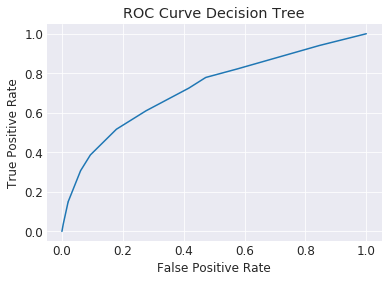

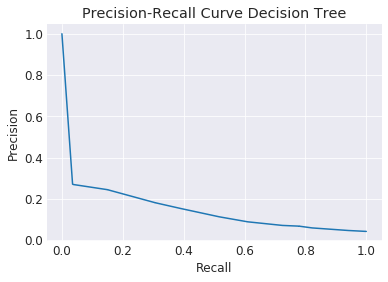

In [34]:
# Best threshold calculation and areas under the curves 
roc_auc_dt_small_medium, pr_auc_dt_small_medium, best_thresh_roc_curve_dt_small_medium, best_thresh_pr_curve_dt_small_medium = find_best_threshold(
    predictions_df = results_dt_small_medium,
    label_col = 'label',
    churn_proba_col = 'churn_probability',
    model_name = 'Decision Tree'
)

In [35]:
# Threshold optimization: with ROC Curve best threshold
predict_test_dt_small_medium = get_optimal_threshold_results(
    predictions_df = predict_test_dt_small_medium, 
    threshold = best_thresh_roc_curve_dt_small_medium,
    proba_col = 'churn_probability',
    new_prediction_col = 'prediction_roc_th'
)
# Threshold optimization: with PR Curve best threshold
predict_test_dt_small_medium = get_optimal_threshold_results(
    predictions_df = predict_test_dt_small_medium, 
    threshold = best_thresh_pr_curve_dt_small_medium,
    proba_col = 'churn_probability',
    new_prediction_col = 'prediction_pr_th'
)

In [36]:
# Computing the new confusion matrix: ROC Curve best threshold
cm_roc_dt_small_medium = conpute_confusion_matrix(predict_test_dt_small_medium, 'prediction_roc_th', 'label')

# Computing the new confusion matrix: PR Curve best threshold
cm_pr_dt_small_medium = conpute_confusion_matrix(predict_test_dt_small_medium, 'prediction_pr_th', 'label')

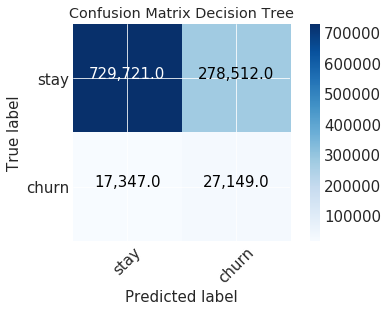

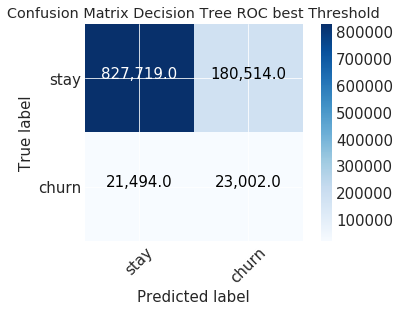

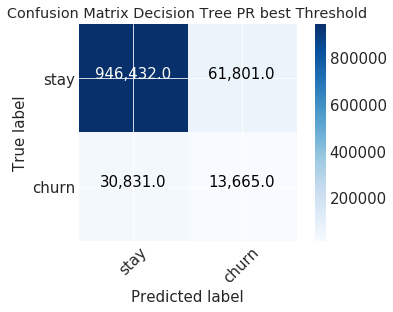

In [37]:
# Evaluation metrics calculation
precision_dt_small_medium, recall_dt_small_medium, fscore_dt_small_medium = evaluate_model(
    confusion_matrix = cm_dt_small_medium,  
    model_name = 'Decision Tree'
)

# Computing new evaluation metrics: ROC Curve best threshold
precision_roc_dt_small_medium, recall_roc_dt_small_medium, fscore_roc_dt_small_medium = evaluate_model(
    confusion_matrix = cm_roc_dt_small_medium,
    model_name = 'Decision Tree ROC best Threshold'
)

# Computing new evaluation metrics: PR Curve best threshold
precision_pr_dt_small_medium, recall_pr_dt_small_medium, fscore_pr_dt_small_medium = evaluate_model(
    confusion_matrix = cm_pr_dt_small_medium,
    model_name = 'Decision Tree PR best Threshold'
)

In [38]:
#Displaying Evaluation metrics as pandas dataframe
metrics_dt_small_medium = metrics_to_pandas(
    model = 'Decision Tree Small-Medium',
    precision = precision_dt_small_medium, 
    recall = recall_dt_small_medium, 
    fscore = fscore_dt_small_medium, 
    roc_auc = roc_auc_dt_small_medium, 
    pr_auc = pr_auc_dt_small_medium
)
print("Metrics before threshold optimization: ")
display(metrics_dt_small_medium)

#Displaying new evaluation metrics: ROC Curve best threshold
metrics_roc_dt_small_medium = metrics_to_pandas(
    model = 'Decision Tree Small-Medium',
    precision = precision_roc_dt_small_medium, 
    recall = recall_roc_dt_small_medium, 
    fscore = fscore_roc_dt_small_medium, 
    roc_auc = roc_auc_dt_small_medium, 
    pr_auc = pr_auc_dt_small_medium,
    roc_best_threshold = best_thresh_roc_curve_dt_small_medium
)

#Displaying new evaluation metrics: PR Curve best threshold
metrics_pr_dt_small_medium = metrics_to_pandas(
    model = 'Decision Tree Small-Medium',
    precision = precision_pr_dt_small_medium, 
    recall = recall_pr_dt_small_medium, 
    fscore = fscore_pr_dt_small_medium, 
    roc_auc = roc_auc_dt_small_medium, 
    pr_auc = pr_auc_dt_small_medium,
    pr_best_threshold = best_thresh_pr_curve_dt_small_medium
)

print("Metrics After threshold optimization - ROC best threshold: ")
display(metrics_roc_dt_small_medium)
print("Metrics After threshold optimization - PR best threshold: ")
display(metrics_pr_dt_small_medium)

Metrics before threshold optimization: 


,Model,Default Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Decision Tree Small-Medium,0.5,8.88206,61.0145,15.5068,0.721413,0.150036


Metrics After threshold optimization - ROC best threshold: 


,Model,ROC Best Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Decision Tree Small-Medium,0.619491,11.3023,51.6945,18.5491,0.721413,0.150036


Metrics After threshold optimization - PR best threshold: 


,Model,PR Best Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Decision Tree Small-Medium,0.803173,18.1075,30.7106,22.7822,0.721413,0.150036


In [39]:
metrics_perc_dict_small_medium['Model'].append('Decision Tree Small-Medium')
metrics_perc_dict_small_medium['Default Threshold'].append(0.5)
metrics_perc_dict_small_medium['Precision (%)'].append(precision_dt_small_medium*100)
metrics_perc_dict_small_medium['Recall (%)'].append(recall_dt_small_medium*100)
metrics_perc_dict_small_medium['F1 Score (%)'].append(fscore_dt_small_medium*100)
metrics_perc_dict_small_medium['ROC AUC'].append(roc_auc_dt_small_medium)
metrics_perc_dict_small_medium['PR AUC'].append(pr_auc_dt_small_medium)

metrics_perc_dict_roc_th_small_medium['Model'].append('Decision Tree Small-Medium')
metrics_perc_dict_roc_th_small_medium['ROC Best Threshold'].append(best_thresh_roc_curve_dt_small_medium)
metrics_perc_dict_roc_th_small_medium['Precision (%)'].append(precision_roc_dt_small_medium*100)
metrics_perc_dict_roc_th_small_medium['Recall (%)'].append(recall_roc_dt_small_medium*100)
metrics_perc_dict_roc_th_small_medium['F1 Score (%)'].append(fscore_roc_dt_small_medium*100)
metrics_perc_dict_roc_th_small_medium['ROC AUC'].append(roc_auc_dt_small_medium)
metrics_perc_dict_roc_th_small_medium['PR AUC'].append(pr_auc_dt_small_medium)

metrics_perc_dict_pr_th_small_medium['Model'].append('Decision Tree Small-Medium')
metrics_perc_dict_pr_th_small_medium['PR Best Threshold'].append(best_thresh_pr_curve_dt_small_medium)
metrics_perc_dict_pr_th_small_medium['Precision (%)'].append(precision_pr_dt_small_medium*100)
metrics_perc_dict_pr_th_small_medium['Recall (%)'].append(recall_pr_dt_small_medium*100)
metrics_perc_dict_pr_th_small_medium['F1 Score (%)'].append(fscore_pr_dt_small_medium*100)
metrics_perc_dict_pr_th_small_medium['ROC AUC'].append(roc_auc_dt_small_medium)
metrics_perc_dict_pr_th_small_medium['PR AUC'].append(pr_auc_dt_small_medium)

## Gradient-boosted tree classifier

#### Building

In [40]:
from pyspark.ml.classification import GBTClassifier, GBTClassificationModel

In [41]:
gbt_small_medium = GBTClassifier(labelCol='label', featuresCol="features", maxIter=50)
gbt_model_small_medium = gbt_small_medium.fit(assembled_train_set_small_medium)
predict_train_gbt_small_medium = gbt_model_small_medium.transform(assembled_train_set_small_medium)
predict_test_gbt_small_medium = gbt_model_small_medium.transform(assembled_test_set_small_medium)

In [42]:
predict_test_gbt_small_medium = split_proba_column(predictions_df = predict_test_gbt_small_medium, proba_col = 'probability')
cm_gbt_small_medium = conpute_confusion_matrix(predict_test_gbt_small_medium, 'prediction', 'label')
results_gbt_small_medium = predict_test_gbt_small_medium.select('label', 'probability', 'stay_probability', 'churn_probability', 'prediction').toPandas()

#### Evaluation

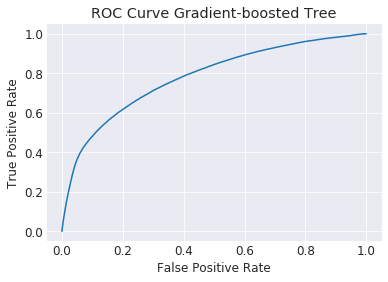

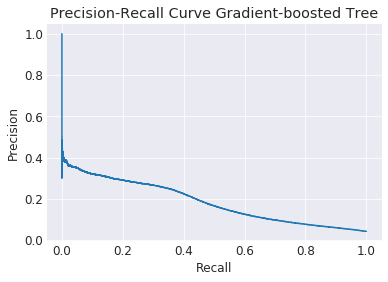

In [43]:
# Best threshold calculation and areas under the curves 
roc_auc_gbt_small_medium, pr_auc_gbt_small_medium, best_thresh_roc_curve_gbt_small_medium, best_thresh_pr_curve_gbt_small_medium = find_best_threshold(
    predictions_df = results_gbt_small_medium,
    label_col = 'label',
    churn_proba_col = 'churn_probability',
    model_name = 'Gradient-boosted Tree'
)

In [44]:
# Threshold optimization: with ROC Curve best threshold
predict_test_gbt_small_medium = get_optimal_threshold_results(
    predictions_df = predict_test_gbt_small_medium, 
    threshold = best_thresh_roc_curve_gbt_small_medium,
    proba_col = 'churn_probability',
    new_prediction_col = 'prediction_roc_th'
)
# Threshold optimization: with PR Curve best threshold
predict_test_gbt_small_medium = get_optimal_threshold_results(
    predictions_df = predict_test_gbt_small_medium, 
    threshold = best_thresh_pr_curve_gbt_small_medium,
    proba_col = 'churn_probability',
    new_prediction_col = 'prediction_pr_th'
)

In [45]:
# Computing the new confusion matrix: ROC Curve best threshold
cm_roc_gbt_small_medium = conpute_confusion_matrix(predict_test_gbt_small_medium, 'prediction_roc_th', 'label')

# Computing the new confusion matrix: PR Curve best threshold
cm_pr_gbt_small_medium = conpute_confusion_matrix(predict_test_gbt_small_medium, 'prediction_pr_th', 'label')

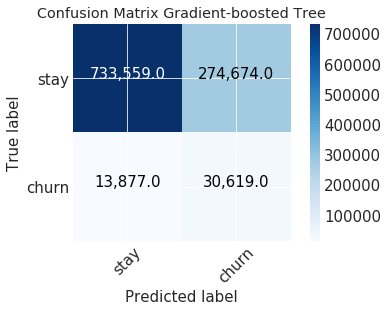

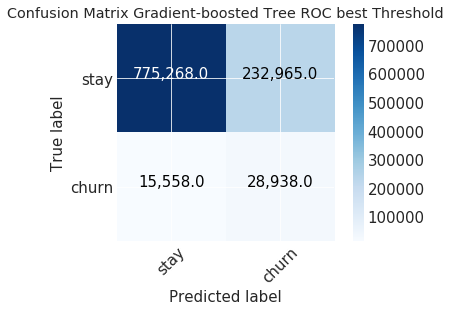

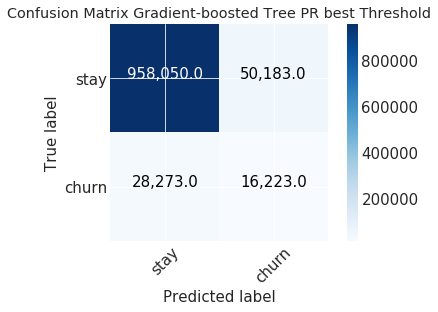

In [46]:
# Evaluation metrics calculation
precision_gbt_small_medium, recall_gbt_small_medium, fscore_gbt_small_medium = evaluate_model(
    confusion_matrix = cm_gbt_small_medium,  
    model_name = 'Gradient-boosted Tree'
)

# Computing new evaluation metrics: ROC Curve best threshold
precision_roc_gbt_small_medium, recall_roc_gbt_small_medium, fscore_roc_gbt_small_medium = evaluate_model(
    confusion_matrix = cm_roc_gbt_small_medium,
    model_name = 'Gradient-boosted Tree ROC best Threshold'
)

# Computing new evaluation metrics: PR Curve best threshold
precision_pr_gbt_small_medium, recall_pr_gbt_small_medium, fscore_pr_gbt_small_medium = evaluate_model(
    confusion_matrix = cm_pr_gbt_small_medium,
    model_name = 'Gradient-boosted Tree PR best Threshold'
)

In [47]:
#Displaying Evaluation metrics as pandas dataframe
metrics_gbt_small_medium = metrics_to_pandas(
    model = 'Gradient-boosted Tree Small-Medium',
    precision = precision_gbt_small_medium, 
    recall = recall_gbt_small_medium, 
    fscore = fscore_gbt_small_medium, 
    roc_auc = roc_auc_gbt_small_medium, 
    pr_auc = pr_auc_gbt_small_medium
)
print("Metrics before threshold optimization: ")
display(metrics_gbt_small_medium)

#Displaying new evaluation metrics: ROC Curve best threshold
metrics_roc_gbt_small_medium = metrics_to_pandas(
    model = 'Gradient-boosted Tree Small-Medium',
    precision = precision_roc_gbt_small_medium, 
    recall = recall_roc_gbt_small_medium, 
    fscore = fscore_roc_gbt_small_medium, 
    roc_auc = roc_auc_gbt_small_medium, 
    pr_auc = pr_auc_gbt_small_medium,
    roc_best_threshold = best_thresh_roc_curve_gbt_small_medium
)

#Displaying new evaluation metrics: PR Curve best threshold
metrics_pr_gbt_small_medium = metrics_to_pandas(
    model = 'Gradient-boosted Tree Small-Medium',
    precision = precision_pr_gbt_small_medium, 
    recall = recall_pr_gbt_small_medium, 
    fscore = fscore_pr_gbt_small_medium, 
    roc_auc = roc_auc_gbt_small_medium, 
    pr_auc = pr_auc_gbt_small_medium,
    pr_best_threshold = best_thresh_pr_curve_gbt_small_medium
)

print("Metrics After threshold optimization - ROC best threshold: ")
display(metrics_roc_gbt_small_medium)
print("Metrics After threshold optimization - PR best threshold: ")
display(metrics_pr_gbt_small_medium)

Metrics before threshold optimization: 


,Model,Default Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Gradient-boosted Tree Small-Medium,0.5,10.0294,68.8129,17.5071,0.779955,0.184047


Metrics After threshold optimization - ROC best threshold: 


,Model,ROC Best Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Gradient-boosted Tree Small-Medium,0.527419,11.0491,65.0351,18.8891,0.779955,0.184047


Metrics After threshold optimization - PR best threshold: 


,Model,PR Best Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Gradient-boosted Tree Small-Medium,0.754061,24.43,36.4595,29.2565,0.779955,0.184047


In [48]:
metrics_perc_dict_small_medium['Model'].append('Gradient-boosted Tree Small-Medium')
metrics_perc_dict_small_medium['Default Threshold'].append(0.5)
metrics_perc_dict_small_medium['Precision (%)'].append(precision_gbt_small_medium*100)
metrics_perc_dict_small_medium['Recall (%)'].append(recall_gbt_small_medium*100)
metrics_perc_dict_small_medium['F1 Score (%)'].append(fscore_gbt_small_medium*100)
metrics_perc_dict_small_medium['ROC AUC'].append(roc_auc_gbt_small_medium)
metrics_perc_dict_small_medium['PR AUC'].append(pr_auc_gbt_small_medium)

metrics_perc_dict_roc_th_small_medium['Model'].append('Gradient-boosted Tree Small-Medium')
metrics_perc_dict_roc_th_small_medium['ROC Best Threshold'].append(best_thresh_roc_curve_gbt_small_medium)
metrics_perc_dict_roc_th_small_medium['Precision (%)'].append(precision_roc_gbt_small_medium*100)
metrics_perc_dict_roc_th_small_medium['Recall (%)'].append(recall_roc_gbt_small_medium*100)
metrics_perc_dict_roc_th_small_medium['F1 Score (%)'].append(fscore_roc_gbt_small_medium*100)
metrics_perc_dict_roc_th_small_medium['ROC AUC'].append(roc_auc_gbt_small_medium)
metrics_perc_dict_roc_th_small_medium['PR AUC'].append(pr_auc_gbt_small_medium)

metrics_perc_dict_pr_th_small_medium['Model'].append('Gradient-boosted Tree Small-Medium')
metrics_perc_dict_pr_th_small_medium['PR Best Threshold'].append(best_thresh_pr_curve_gbt_small_medium)
metrics_perc_dict_pr_th_small_medium['Precision (%)'].append(precision_pr_gbt_small_medium*100)
metrics_perc_dict_pr_th_small_medium['Recall (%)'].append(recall_pr_gbt_small_medium*100)
metrics_perc_dict_pr_th_small_medium['F1 Score (%)'].append(fscore_pr_gbt_small_medium*100)
metrics_perc_dict_pr_th_small_medium['ROC AUC'].append(roc_auc_gbt_small_medium)
metrics_perc_dict_pr_th_small_medium['PR AUC'].append(pr_auc_gbt_small_medium)

In [14]:
#with open(os.getcwd()+"/results/metrics_perc_dict_small_medium_3m.pickle", 'wb') as file:
#    pickle.dump(metrics_perc_dict_small_medium, file, protocol=pickle.HIGHEST_PROTOCOL)
#
#with open(os.getcwd()+"/results/metrics_perc_dict_roc_th_small_medium_3m.pickle", 'wb') as file:
#    pickle.dump(metrics_perc_dict_roc_th_small_medium, file, protocol=pickle.HIGHEST_PROTOCOL)
#    
#with open(os.getcwd()+"/results/metrics_perc_dict_pr_th_small_medium_3m.pickle", 'wb') as file:
#    pickle.dump(metrics_perc_dict_pr_th_small_medium, file, protocol=pickle.HIGHEST_PROTOCOL)


with open(os.getcwd()+"/results/metrics_perc_dict_small_medium_3m.pickle", 'rb') as file:
    metrics_perc_dict_small_medium = pickle.load(file)

with open(os.getcwd()+"/results/metrics_perc_dict_roc_th_small_medium_3m.pickle", 'rb') as file:
    metrics_perc_dict_roc_th_small_medium = pickle.load(file)

with open(os.getcwd()+"/results/metrics_perc_dict_pr_th_small_medium_3m.pickle", 'rb') as file:
    metrics_perc_dict_pr_th_small_medium = pickle.load(file)

In [15]:
#with open(os.getcwd()+"/results/results_lr_small_medium.pickle", 'wb') as file:
#    pickle.dump(results_lr_small_medium, file, protocol=pickle.HIGHEST_PROTOCOL)
#
#with open(os.getcwd()+"/results/results_rf_small_medium.pickle", 'wb') as file:
#    pickle.dump(results_rf_small_medium, file, protocol=pickle.HIGHEST_PROTOCOL)
#    
#with open(os.getcwd()+"/results/results_dt_small_medium.pickle", 'wb') as file:
#    pickle.dump(results_dt_small_medium, file, protocol=pickle.HIGHEST_PROTOCOL)
#    
#with open(os.getcwd()+"/results/results_gbt_small_medium.pickle", 'wb') as file:
#    pickle.dump(results_gbt_small_medium, file, protocol=pickle.HIGHEST_PROTOCOL)


with open(os.getcwd()+"/results/results_lr_small_medium.pickle", 'rb') as file:
    results_lr_small_medium = pickle.load(file)

with open(os.getcwd()+"/results/results_rf_small_medium.pickle", 'rb') as file:
    results_rf_small_medium = pickle.load(file)

with open(os.getcwd()+"/results/results_dt_small_medium.pickle", 'rb') as file:
    results_dt_small_medium = pickle.load(file)

with open(os.getcwd()+"/results/results_gbt_small_medium.pickle", 'rb') as file:
    results_gbt_small_medium = pickle.load(file)

### XGBoost

In [16]:
from pysparkling.ml import H2OXGBoost
from h2o.estimators.xgboost import H2OXGBoostEstimator
from pysparkling import *
import h2o

In [17]:
hc = None

In [18]:
if hc is None:
    conf = H2OConf().set('spark.dynamicAllocation.enabled', False).setInternalClusterMode()
    # Default value True causes this error:  IllegalArgumentException: 'Unsupported argument: (spark.dynamicAllocation.enabled,true)'
    hc = H2OContext.getOrCreate(conf)

Connecting to H2O server at http://10.151.55.251:54321 ... successful.


H2O_cluster_uptime:,19 secs
H2O_cluster_timezone:,Europe/Rome
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,5 months !!!
H2O_cluster_name:,sparkling-water-anxadvuser_application_1610346897105_0854
H2O_cluster_total_nodes:,4
H2O_cluster_free_memory:,54.80 Gb
H2O_cluster_total_cores:,128
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"



Sparkling Water Context:
 * Sparkling Water Version: 3.30.1.1-1-2.4
 * H2O name: anxadvuser
 * cluster size: 4
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (0,10.151.55.251,54321)
  (1,10.151.55.251,54323)
  (2,10.151.55.251,54325)
  (3,10.151.55.251,54327)
  ------------------------

  Open H2O Flow in browser: http://claawme2ba29.enelint.global:54321 (CMD + click in Mac OSX)

    
 * Yarn App ID of Spark application: application_1610346897105_0854
    


#### Building

In [19]:
xgb_small_medium = H2OXGBoost(
    quietMode=True,
    ntrees=50,
    maxDepth=6,
    minRows=1.0,
    minChildWeight=1.0,
    learnRate=0.02,
    sampleRate=1.0,
    subsample=1.0,
    colSampleRate=1.0,
    colSampleByLevel=1.0,
    colSampleRatePerTree=0.7,
    colSampleByTree=1.0,
    maxAbsLeafnodePred=0.0,
    maxDeltaStep=0.0,
    scoreTreeInterval=0,
    minSplitImprovement=0.0,
    gamma=0.0,
    nthread=-1,
    maxBins=256,
    maxLeaves=0,
    treeMethod="hist",
    growPolicy="lossguide",
    booster="gbtree",
    dmatrixType="auto",
    regLambda=0.0,
    regAlpha=0.0,
    sampleType="uniform",
    normalizeType="tree",
    rateDrop=0.0,
    oneDrop=False,
    skipDrop=0.0,
    gpuId=0,
    backend="auto",
    modelId=None,
    keepCrossValidationPredictions=False,
    keepCrossValidationFoldAssignment=False,
    parallelizeCrossValidation=True,
    distribution="AUTO",
    labelCol=labelCol,              # TARGET FEATURE
    featuresCols=train_set_assembled_col_names_small_medium, # TRAIN FEATURES
    foldCol=None,
    weightCol=None,
    offsetCol=None,
    splitRatio=1.0,
    seed=-1,
    nfolds=0,
    columnsToCategorical=[],
    predictionCol="prediction",
    detailedPredictionCol="detailed_prediction",
    withDetailedPredictionCol=True,
    convertUnknownCategoricalLevelsToNa=False,
    convertInvalidNumbersToNa=False,
    namedMojoOutputColumns=True,
    monotoneConstraints={},
    stoppingRounds=0,
    stoppingMetric="AUTO",
    stoppingTolerance=0.001,
    withContributions=False
)

In [20]:
xgb_model_small_medium = xgb_small_medium.fit(train_set_features_selected_small_medium)

In [21]:
predict_train_xgb_small_medium = xgb_model_small_medium.transform(train_set_features_selected_small_medium)
predict_test_xgb_small_medium = xgb_model_small_medium.transform(test_set_features_selected_small_medium)

In [22]:
predict_test_xgb_small_medium = get_optimal_threshold_results(
    predictions_df = predict_test_xgb_small_medium, 
    threshold = 0.5,
    proba_col = 'prediction',
    new_prediction_col = 'predicted_label'
)

In [23]:
cm_xgb_small_medium = conpute_confusion_matrix(predict_test_xgb_small_medium, 'predicted_label', labelCol)
results_xgb_small_medium = predict_test_xgb_small_medium.select(labelCol, 'prediction', 'predicted_label').toPandas()

#### Evaluation

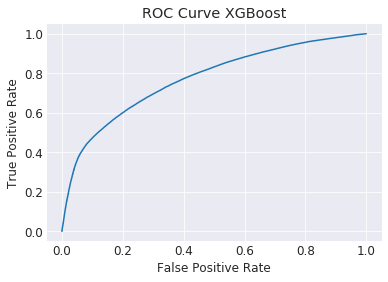

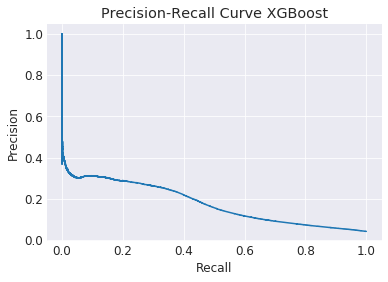

In [24]:
# Best threshold calculation and areas under the curves 
roc_auc_xgb_small_medium, pr_auc_xgb_small_medium, best_thresh_roc_curve_xgb_small_medium, best_thresh_pr_curve_xgb_small_medium = find_best_threshold(
    predictions_df = results_xgb_small_medium,
    label_col = labelCol,
    churn_proba_col = 'prediction',
    model_name = 'XGBoost'
)

In [25]:
# Threshold optimization: with ROC Curve best threshold
predict_test_xgb_small_medium = get_optimal_threshold_results(
    predictions_df = predict_test_xgb_small_medium, 
    threshold = best_thresh_roc_curve_xgb_small_medium,
    proba_col = 'prediction',
    new_prediction_col = 'predicted_label_roc_th'
)
# Threshold optimization: with PR Curve best threshold
predict_test_xgb_small_medium = get_optimal_threshold_results(
    predictions_df = predict_test_xgb_small_medium, 
    threshold = best_thresh_pr_curve_xgb_small_medium,
    proba_col = 'prediction',
    new_prediction_col = 'predicted_label_pr_th'
)

In [26]:
# Computing the new confusion matrix: ROC Curve best threshold
cm_roc_xgb_small_medium = conpute_confusion_matrix(predict_test_xgb_small_medium, 'predicted_label_roc_th', labelCol)

# Computing the new confusion matrix: PR Curve best threshold
cm_pr_xgb_small_medium = conpute_confusion_matrix(predict_test_xgb_small_medium, 'predicted_label_pr_th', labelCol)

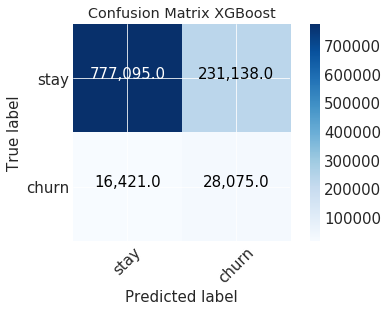

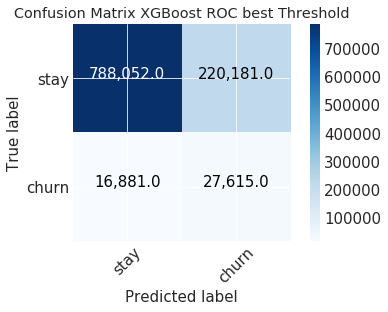

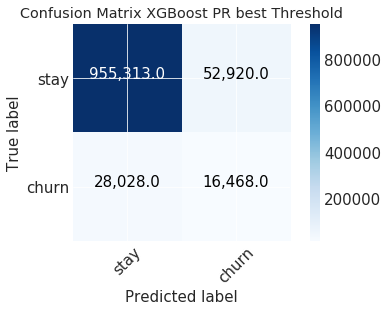

In [27]:
# Evaluation metrics calculation
precision_xgb_small_medium, recall_xgb_small_medium, fscore_xgb_small_medium = evaluate_model(
    confusion_matrix = cm_xgb_small_medium,  
    model_name = 'XGBoost'
)

# Computing new evaluation metrics: ROC Curve best threshold
precision_roc_xgb_small_medium, recall_roc_xgb_small_medium, fscore_roc_xgb_small_medium = evaluate_model(
    confusion_matrix = cm_roc_xgb_small_medium,
    model_name = 'XGBoost ROC best Threshold'
)

# Computing new evaluation metrics: PR Curve best threshold
precision_pr_xgb_small_medium, recall_pr_xgb_small_medium, fscore_pr_xgb_small_medium = evaluate_model(
    confusion_matrix = cm_pr_xgb_small_medium,
    model_name = 'XGBoost PR best Threshold'
)

In [28]:
#Displaying Evaluation metrics as pandas dataframe
metrics_xgb_small_medium = metrics_to_pandas(
    model = 'XGBoost Small-Medium',
    precision = precision_xgb_small_medium, 
    recall = recall_xgb_small_medium, 
    fscore = fscore_xgb_small_medium, 
    roc_auc = roc_auc_xgb_small_medium, 
    pr_auc = pr_auc_xgb_small_medium
)
print("Metrics before threshold optimization: ")
display(metrics_xgb_small_medium)

#Displaying new evaluation metrics: ROC Curve best threshold
metrics_roc_xgb_small_medium = metrics_to_pandas(
    model = 'XGBoost Small-Medium',
    precision = precision_roc_xgb_small_medium, 
    recall = recall_roc_xgb_small_medium, 
    fscore = fscore_roc_xgb_small_medium, 
    roc_auc = roc_auc_xgb_small_medium, 
    pr_auc = pr_auc_xgb_small_medium,
    roc_best_threshold = best_thresh_roc_curve_xgb_small_medium
)

#Displaying new evaluation metrics: PR Curve best threshold
metrics_pr_xgb_small_medium = metrics_to_pandas(
    model = 'XGBoost Small-Medium',
    precision = precision_pr_xgb_small_medium, 
    recall = recall_pr_xgb_small_medium, 
    fscore = fscore_pr_xgb_small_medium, 
    roc_auc = roc_auc_xgb_small_medium, 
    pr_auc = pr_auc_xgb_small_medium,
    pr_best_threshold = best_thresh_pr_curve_xgb_small_medium
)

print("Metrics After threshold optimization - ROC best threshold: ")
display(metrics_roc_xgb_small_medium)
print("Metrics After threshold optimization - PR best threshold: ")
display(metrics_pr_xgb_small_medium)

Metrics before threshold optimization: 


,Model,Default Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,XGBoost Small-Medium,0.5,10.8309,63.0956,18.4881,0.770731,0.177088


Metrics After threshold optimization - ROC best threshold: 


,Model,ROC Best Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,XGBoost Small-Medium,0.502929,11.1442,62.0618,18.8955,0.770731,0.177088


Metrics After threshold optimization - PR best threshold: 


,Model,PR Best Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,XGBoost Small-Medium,0.611794,23.7332,37.0101,28.9207,0.770731,0.177088


In [29]:
metrics_perc_dict_small_medium['Model'].append('XGBoost Small-Medium')
metrics_perc_dict_small_medium['Default Threshold'].append(0.5)
metrics_perc_dict_small_medium['Precision (%)'].append(precision_xgb_small_medium*100)
metrics_perc_dict_small_medium['Recall (%)'].append(recall_xgb_small_medium*100)
metrics_perc_dict_small_medium['F1 Score (%)'].append(fscore_xgb_small_medium*100)
metrics_perc_dict_small_medium['ROC AUC'].append(roc_auc_xgb_small_medium)
metrics_perc_dict_small_medium['PR AUC'].append(pr_auc_xgb_small_medium)

metrics_perc_dict_roc_th_small_medium['Model'].append('XGBoost Small-Medium')
metrics_perc_dict_roc_th_small_medium['ROC Best Threshold'].append(best_thresh_roc_curve_xgb_small_medium)
metrics_perc_dict_roc_th_small_medium['Precision (%)'].append(precision_roc_xgb_small_medium*100)
metrics_perc_dict_roc_th_small_medium['Recall (%)'].append(recall_roc_xgb_small_medium*100)
metrics_perc_dict_roc_th_small_medium['F1 Score (%)'].append(fscore_roc_xgb_small_medium*100)
metrics_perc_dict_roc_th_small_medium['ROC AUC'].append(roc_auc_xgb_small_medium)
metrics_perc_dict_roc_th_small_medium['PR AUC'].append(pr_auc_xgb_small_medium)

metrics_perc_dict_pr_th_small_medium['Model'].append('XGBoost Small-Medium')
metrics_perc_dict_pr_th_small_medium['PR Best Threshold'].append(best_thresh_pr_curve_xgb_small_medium)
metrics_perc_dict_pr_th_small_medium['Precision (%)'].append(precision_pr_xgb_small_medium*100)
metrics_perc_dict_pr_th_small_medium['Recall (%)'].append(recall_pr_xgb_small_medium*100)
metrics_perc_dict_pr_th_small_medium['F1 Score (%)'].append(fscore_pr_xgb_small_medium*100)
metrics_perc_dict_pr_th_small_medium['ROC AUC'].append(roc_auc_xgb_small_medium)
metrics_perc_dict_pr_th_small_medium['PR AUC'].append(pr_auc_xgb_small_medium)

# Summary

In [57]:
#with open(os.getcwd()+"/results/metrics_perc_dict_small_medium_3m.pickle", 'wb') as file:
#    pickle.dump(metrics_perc_dict_small_medium, file, protocol=pickle.HIGHEST_PROTOCOL)
#
#with open(os.getcwd()+"/results/metrics_perc_dict_roc_th_small_medium_3m.pickle", 'wb') as file:
#    pickle.dump(metrics_perc_dict_roc_th_small_medium, file, protocol=pickle.HIGHEST_PROTOCOL)
#    
#with open(os.getcwd()+"/results/metrics_perc_dict_pr_th_small_medium_3m.pickle", 'wb') as file:
#    pickle.dump(metrics_perc_dict_pr_th_small_medium, file, protocol=pickle.HIGHEST_PROTOCOL)


with open(os.getcwd()+"/results/metrics_perc_dict_small_medium_3m.pickle", 'rb') as file:
    metrics_perc_dict_small_medium = pickle.load(file)

with open(os.getcwd()+"/results/metrics_perc_dict_roc_th_small_medium_3m.pickle", 'rb') as file:
    metrics_perc_dict_roc_th_small_medium = pickle.load(file)

with open(os.getcwd()+"/results/metrics_perc_dict_pr_th_small_medium_3m.pickle", 'rb') as file:
    metrics_perc_dict_pr_th_small_medium = pickle.load(file)

In [30]:
display(pd.DataFrame.from_dict(metrics_perc_dict_small_medium, orient='index').transpose())
display(pd.DataFrame.from_dict(metrics_perc_dict_roc_th_small_medium, orient='index').transpose())
display(pd.DataFrame.from_dict(metrics_perc_dict_pr_th_small_medium, orient='index').transpose())

,Model,Default Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Logistic Regression Small-Medium,0.5,7.82659,63.6911,13.9402,0.709553,0.12704
1,Random Forest Small-Medium,0.5,8.04307,66.2329,14.3442,0.727338,0.134614
2,Decision Tree Small-Medium,0.5,8.88206,61.0145,15.5068,0.721413,0.150036
3,Gradient-boosted Tree Small-Medium,0.5,10.0294,68.8129,17.5071,0.779955,0.184047
4,XGBoost Small-Medium,0.5,10.8309,63.0956,18.4881,0.770731,0.177088


,Model,ROC Best Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Logistic Regression Small-Medium,0.516041,8.45453,59.1716,14.7951,0.709553,0.12704
1,Random Forest Small-Medium,0.502633,8.19466,65.0418,14.5555,0.727338,0.134614
2,Decision Tree Small-Medium,0.619491,11.3023,51.6945,18.5491,0.721413,0.150036
3,Gradient-boosted Tree Small-Medium,0.527419,11.0491,65.0351,18.8891,0.779955,0.184047
4,XGBoost Small-Medium,0.502929,11.1442,62.0618,18.8955,0.770731,0.177088


,Model,PR Best Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Logistic Regression Small-Medium,0.711785,18.4796,27.5283,22.1141,0.709553,0.12704
1,Random Forest Small-Medium,0.59424,19.2059,27.1238,22.4883,0.727338,0.134614
2,Decision Tree Small-Medium,0.803173,18.1075,30.7106,22.7822,0.721413,0.150036
3,Gradient-boosted Tree Small-Medium,0.754061,24.43,36.4595,29.2565,0.779955,0.184047
4,XGBoost Small-Medium,0.611794,23.7332,37.0101,28.9207,0.770731,0.177088


## PR and ROC curves

In [31]:
np.seterr(divide='ignore', invalid='ignore')

label_cols = ['label', 'label', 'label', 'label', 'val_churn_3_months']
churn_proba_cols = ['churn_probability', 'churn_probability', 'churn_probability', 'churn_probability', 'prediction']
predictions_dfs = [results_lr_small_medium, results_rf_small_medium, results_dt_small_medium, results_gbt_small_medium, results_xgb_small_medium]
labels = ['LR', 'RF', 'DT', 'GBT', 'XGB']

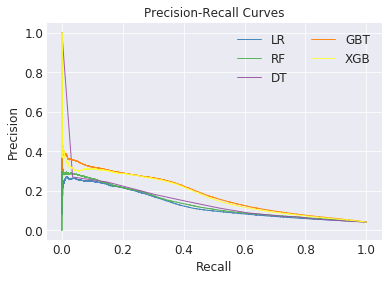

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [32]:
# style
plt.style.use('seaborn-darkgrid')

# create a color palette
palette = plt.get_cmap('Set1')

# multiple line plot
for i in range(len(predictions_dfs)):
    predictions_df = predictions_dfs[i]
    label_col = label_cols[i]
    churn_proba_col = churn_proba_cols[i]

    y = predictions_df[label_col]
    y_hat = predictions_df[churn_proba_col]

    # calculate inputs for the PR curve
    precision, recall, thresholds = precision_recall_curve(y, y_hat)

    # plot PR curve
    plt.plot(recall, precision, marker='', color=palette(i+1), linewidth=1, alpha=0.9, label=labels[i])

# Add legend
plt.legend(loc=1, ncol=2)
 
# Add titles
plt.title("Precision-Recall Curves", loc='center', fontsize=12)
plt.xlabel("Recall")
plt.ylabel("Precision")
#plt.figure(figsize=(30, 25))

# show the plot
plt.show()
plt.close()

np.seterr(divide='warn', invalid='warn')

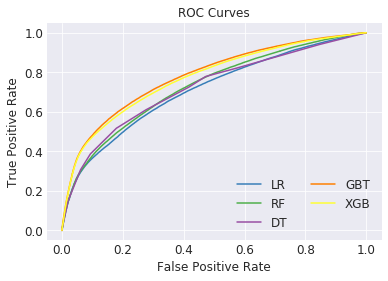

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [33]:
# style
plt.style.use('seaborn-darkgrid')

# create a color palette
palette = plt.get_cmap('Set1')

# multiple line plot
for i in range(len(predictions_dfs)):
    predictions_df = predictions_dfs[i]
    label_col = label_cols[i]
    churn_proba_col = churn_proba_cols[i]

    y = predictions_df[label_col]
    y_hat = predictions_df[churn_proba_col]
    
    # calculate inputs for the roc curve
    fpr, tpr, thresholds = roc_curve(y, y_hat)

    # plot PR curve
    plt.plot(fpr, tpr, marker='', color=palette(i+1), linewidth=1.5, alpha=1, label=labels[i])

# Add legend
plt.legend(loc=4, ncol=2)
 
# Add titles
plt.title("ROC Curves", loc='center', fontsize=12)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#plt.figure(figsize=(30, 25))

# show the plot
plt.show()
plt.close()

np.seterr(divide='warn', invalid='warn')

### Let's try the new target with our best model

In [21]:
gbt_small_medium_final_3_months = GBTClassifier(
    labelCol='label', featuresCol="features", maxDepth = best_params['maxDepth'], maxBins = best_params['maxBins'], 
    minInstancesPerNode = best_params['minInstancesPerNode'], checkpointInterval = best_params['checkpointInterval'], 
    maxIter = best_params['maxIter'], stepSize = best_params['stepSize'], subsamplingRate = best_params['subsamplingRate']
)

In [22]:
gbt_model_small_medium_final_3_months = gbt_small_medium_final_3_months.fit(assembled_train_set_small_medium)

In [23]:
predict_test_gbt_small_medium_final_3_months = gbt_model_small_medium_final_3_months.transform(assembled_test_set_small_medium)

In [26]:
#gbt_model_small_medium_final_3_months.save('/bda/anx_adv_achurn/durand/models/gbt_model_small_medium_final_3_months')
gbt_model_small_medium_final_3_months = GBTClassificationModel.load('/bda/anx_adv_achurn/durand/models/gbt_model_small_medium_final_3_months')

In [27]:
features_imp_pd_3_months = (
     pd.DataFrame(
       gbt_model_small_medium_final_3_months.featureImportances.toArray(), 
       index=train_set_assembled_col_names_small_medium, 
       columns=['importance'])
)
features_imp_pd_3_months.sort_values(by=['importance'], ascending=False)

,importance
qta_days_since_last_inbound_contact,0.024668
idn_sito_sk,0.024456
sds_categoria_ateco_intermedia_embed5,0.023443
val_perc_Abitazioni_Residenti,0.022700
val_perc_Famiglie_Alloggio_Altro,0.022662
val_perc_Famiglie_6+_Componente,0.022317
val_Altitudine_del_centro,0.021905
val_pop_res_totale_15_anni_e_piu_non_appartenente_alle_forze_di_lavoro_nfl,0.021853
val_perc_Famiglie_3_Componente,0.021828
qta_cnt_contatti_outbound_all_channel_m3,0.021738


In [28]:
predict_test_gbt_small_medium_final_3_months = split_proba_column(predictions_df = predict_test_gbt_small_medium_final_3_months, proba_col = 'probability')
cm_gbt_small_medium_final_3_months = conpute_confusion_matrix(predict_test_gbt_small_medium_final_3_months, 'prediction', 'label')
results_gbt_small_medium_final_3_months = predict_test_gbt_small_medium_final_3_months.select('label', 'probability', 'stay_probability', 'churn_probability', 'prediction').toPandas()

#### Evaluation

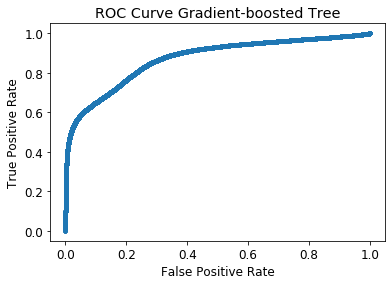

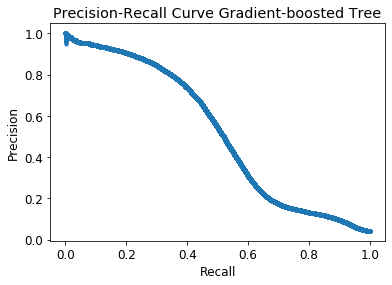

In [29]:
# Best threshold calculation and areas under the curves 
roc_auc_gbt_small_medium_final_3_months, pr_auc_gbt_small_medium_final_3_months, best_thresh_roc_curve_gbt_small_medium_final_3_months, best_thresh_pr_curve_gbt_small_medium_final_3_months = find_best_threshold(
    predictions_df = results_gbt_small_medium_final_3_months,
    label_col = 'label',
    churn_proba_col = 'churn_probability',
    model_name = 'Gradient-boosted Tree'
)

In [30]:
# Threshold optimization: with ROC Curve best threshold
predict_test_gbt_small_medium_final_3_months = get_optimal_threshold_results(
    predictions_df = predict_test_gbt_small_medium_final_3_months, 
    threshold = best_thresh_roc_curve_gbt_small_medium_final_3_months,
    proba_col = 'churn_probability',
    new_prediction_col = 'prediction_roc_th'
)
# Threshold optimization: with PR Curve best threshold
predict_test_gbt_small_medium_final_3_months = get_optimal_threshold_results(
    predictions_df = predict_test_gbt_small_medium_final_3_months, 
    threshold = best_thresh_pr_curve_gbt_small_medium_final_3_months,
    proba_col = 'churn_probability',
    new_prediction_col = 'prediction_pr_th'
)

In [31]:
# Computing the new confusion matrix: ROC Curve best threshold
cm_roc_gbt_small_medium_final_3_months = conpute_confusion_matrix(predict_test_gbt_small_medium_final_3_months, 'prediction_roc_th', 'label')

# Computing the new confusion matrix: PR Curve best threshold
cm_pr_gbt_small_medium_final_3_months = conpute_confusion_matrix(predict_test_gbt_small_medium_final_3_months, 'prediction_pr_th', 'label')

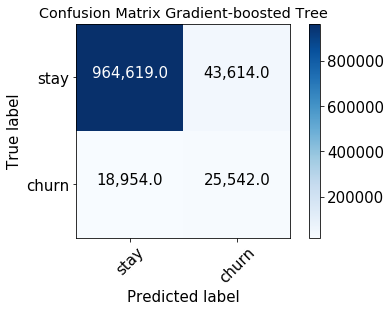

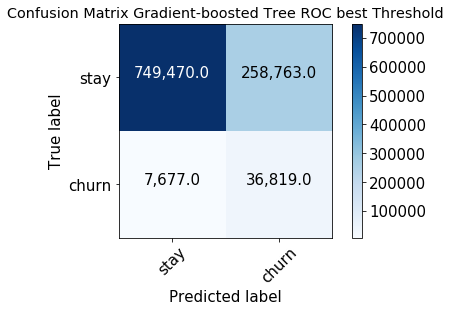

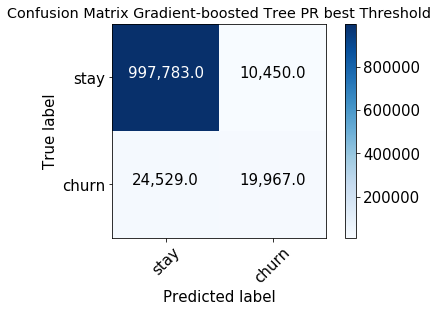

In [32]:
# Evaluation metrics calculation
precision_gbt_small_medium_final_3_months, recall_gbt_small_medium_final_3_months, fscore_gbt_small_medium_final_3_months = evaluate_model(
    confusion_matrix = cm_gbt_small_medium_final_3_months,  
    model_name = 'Gradient-boosted Tree'
)

# Computing new evaluation metrics: ROC Curve best threshold
precision_roc_gbt_small_medium_final_3_months, recall_roc_gbt_small_medium_final_3_months, fscore_roc_gbt_small_medium_final_3_months = evaluate_model(
    confusion_matrix = cm_roc_gbt_small_medium_final_3_months,
    model_name = 'Gradient-boosted Tree ROC best Threshold'
)

# Computing new evaluation metrics: PR Curve best threshold
precision_pr_gbt_small_medium_final_3_months, recall_pr_gbt_small_medium_final_3_months, fscore_pr_gbt_small_medium_final_3_months = evaluate_model(
    confusion_matrix = cm_pr_gbt_small_medium_final_3_months,
    model_name = 'Gradient-boosted Tree PR best Threshold'
)

In [33]:
#Displaying Evaluation metrics as pandas dataframe
metrics_gbt_small_medium_final_3_months = metrics_to_pandas(
    model = 'Gradient-boosted Tree Small-Medium-Final',
    precision = precision_gbt_small_medium_final_3_months, 
    recall = recall_gbt_small_medium_final_3_months, 
    fscore = fscore_gbt_small_medium_final_3_months, 
    roc_auc = roc_auc_gbt_small_medium_final_3_months, 
    pr_auc = pr_auc_gbt_small_medium_final_3_months
)
print("Metrics before threshold optimization: ")
display(metrics_gbt_small_medium_final_3_months)

#Displaying new evaluation metrics: ROC Curve best threshold
metrics_roc_gbt_small_medium_final_3_months = metrics_to_pandas(
    model = 'Gradient-boosted Tree Small-Medium-Final',
    precision = precision_roc_gbt_small_medium_final_3_months, 
    recall = recall_roc_gbt_small_medium_final_3_months, 
    fscore = fscore_roc_gbt_small_medium_final_3_months, 
    roc_auc = roc_auc_gbt_small_medium_final_3_months, 
    pr_auc = pr_auc_gbt_small_medium_final_3_months,
    roc_best_threshold = best_thresh_roc_curve_gbt_small_medium_final_3_months
)

#Displaying new evaluation metrics: PR Curve best threshold
metrics_pr_gbt_small_medium_final_3_months = metrics_to_pandas(
    model = 'Gradient-boosted Tree Small-Medium-Final',
    precision = precision_pr_gbt_small_medium_final_3_months, 
    recall = recall_pr_gbt_small_medium_final_3_months, 
    fscore = fscore_pr_gbt_small_medium_final_3_months, 
    roc_auc = roc_auc_gbt_small_medium_final_3_months, 
    pr_auc = pr_auc_gbt_small_medium_final_3_months,
    pr_best_threshold = best_thresh_pr_curve_gbt_small_medium_final_3_months
)

print("Metrics After threshold optimization - ROC best threshold: ")
display(metrics_roc_gbt_small_medium_final_3_months)
print("Metrics After threshold optimization - PR best threshold: ")
display(metrics_pr_gbt_small_medium_final_3_months)

Metrics before threshold optimization: 


,Model,Default Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Gradient-boosted Tree Small-Medium-Final,0.5,36.9339,57.4029,44.9477,0.871179,0.518616


Metrics After threshold optimization - ROC best threshold: 


,Model,ROC Best Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Gradient-boosted Tree Small-Medium-Final,0.0958046,12.4564,82.7468,21.6533,0.871179,0.518616


Metrics After threshold optimization - PR best threshold: 


,Model,PR Best Threshold,Precision (%),Recall (%),F1 Score (%),ROC AUC,PR AUC
0,Gradient-boosted Tree Small-Medium-Final,0.704147,65.6442,44.8737,53.3072,0.871179,0.518616


In [26]:
session.stop()